In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import matplotlib
matplotlib.rcParams['figure.dpi'] = 150
matplotlib.rcParams['figure.facecolor'] = 'w'
import warnings
warnings.filterwarnings('ignore')

In [2]:
from decodanda import *
np.random.seed(1123)



### First example: neurons respond to one variable
In this example, we have a simple scenario where neurons respond to a single binary variable that can take two values. We will try to decode these two values from neural activity.


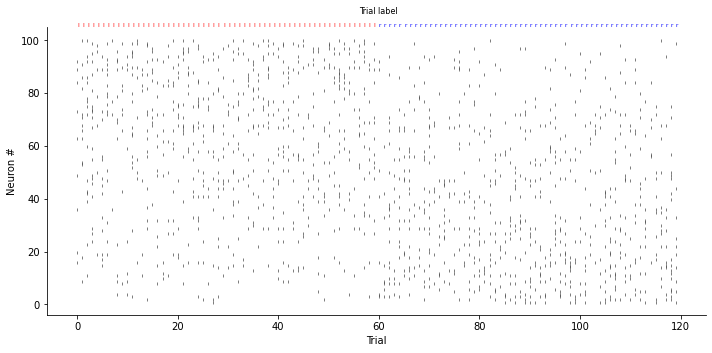

In [3]:
# let's create some data that responds to a binary variable

activity, labels = generate_AB_activity(n_neurons=100, n_trials=120, separation=2.0, labelA='l', labelB='r')

visualize_AB_activity(labels, activity)

session_0 = {
    'Neural Data': activity,
    'Position': labels,
    'Trial Number': np.arange(len(labels))     # specifying that each vector is an independent trial that we can use for decoding
}


In [4]:
# Create a decodanda object by applying these conditions to the data

decodanda_params = {
    'neural_attr': 'Neural Data',       # the key to get the neural activity
    'trial_attr': 'Trial Number',   # the key for the trial number to be used in cross validation
    'verbose': True
}

mydec = Decodanda(data=session_0,
                  conditions={
                      'Position': ['l', 'r']     # The conditions dictionary takes a simple one-variable list here.
                  },
                  **decodanda_params)

		[Decodanda]	building conditioned rasters for session 0
			(Position = l):	Selected 60 time bin out of 120, divided into 60 trials 
			(Position = r):	Selected 60 time bin out of 120, divided into 60 trials 




#### The decode() method

  0%|          | 0/10 [00:00<?, ?it/s]


Testing decoding performance for semantic dichotomy:  Position

[decode_dichotomy]	Decoding - 488 time bins - 244 neurons - 3 brains
		(r)
			vs.
		(l)

Looping over decoding cross validation folds:

[decode_with_nullmodel]	 data <p> = 0.92

[decode_with_nullmodel]	Looping over null model shuffles.


100%|██████████| 10/10 [00:01<00:00,  7.04it/s]


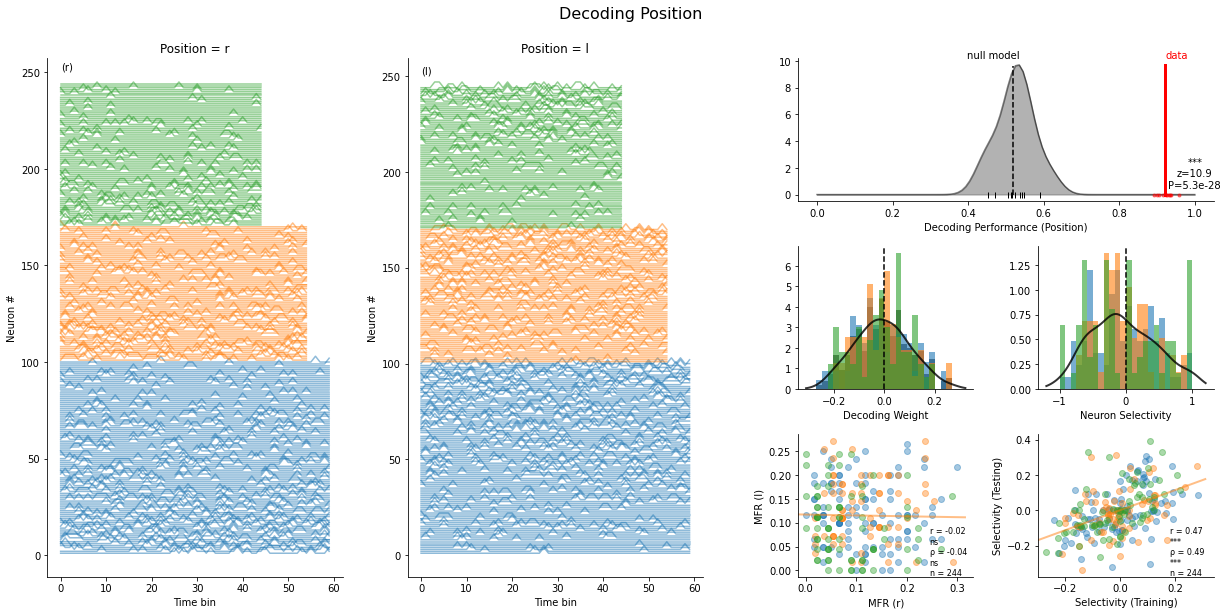

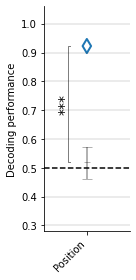

In [10]:
decoding_params = {
    'training_fraction': 0.7,       # fraction of trials used for training during cross validation
    'cross_validations': 10,        # number of different training-testing separations
    'nshuffles': 10,                # number of null model repetitions to compute significance
    'plot': True,                   # this generates a recap plot with performance, null model bars, and significance
    'plot_all': True                # this generates a large plot with a few visualizations of the data and of the results
}

data, null = mydec.decode(**decoding_params)





### Pseudo-population
Pseudo-simultaneous data are automatically built when a list of sessions is specified instead of a single data set.


 60%|██████    | 6/10 [00:00<00:00, 49.27it/s]

		[Decodanda]	building conditioned rasters for session 0
			(Position = l):	Selected 60 time bin out of 120, divided into 60 trials 
			(Position = r):	Selected 60 time bin out of 120, divided into 60 trials 


		[Decodanda]	building conditioned rasters for session 1
			(Position = l):	Selected 55 time bin out of 110, divided into 55 trials 
			(Position = r):	Selected 55 time bin out of 110, divided into 55 trials 


		[Decodanda]	building conditioned rasters for session 2
			(Position = l):	Selected 45 time bin out of 90, divided into 45 trials 
			(Position = r):	Selected 45 time bin out of 90, divided into 45 trials 



Testing decoding performance for semantic dichotomy:  Position

[decode_dichotomy]	Decoding - 492 time bins - 246 neurons - 3 brains
		(r)
			vs.
		(l)

Looping over decoding cross validation folds:


  0%|          | 0/10 [00:00<?, ?it/s]


[decode_with_nullmodel]	 data <p> = 0.88

[decode_with_nullmodel]	Looping over null model shuffles.


100%|██████████| 10/10 [00:01<00:00,  6.24it/s]


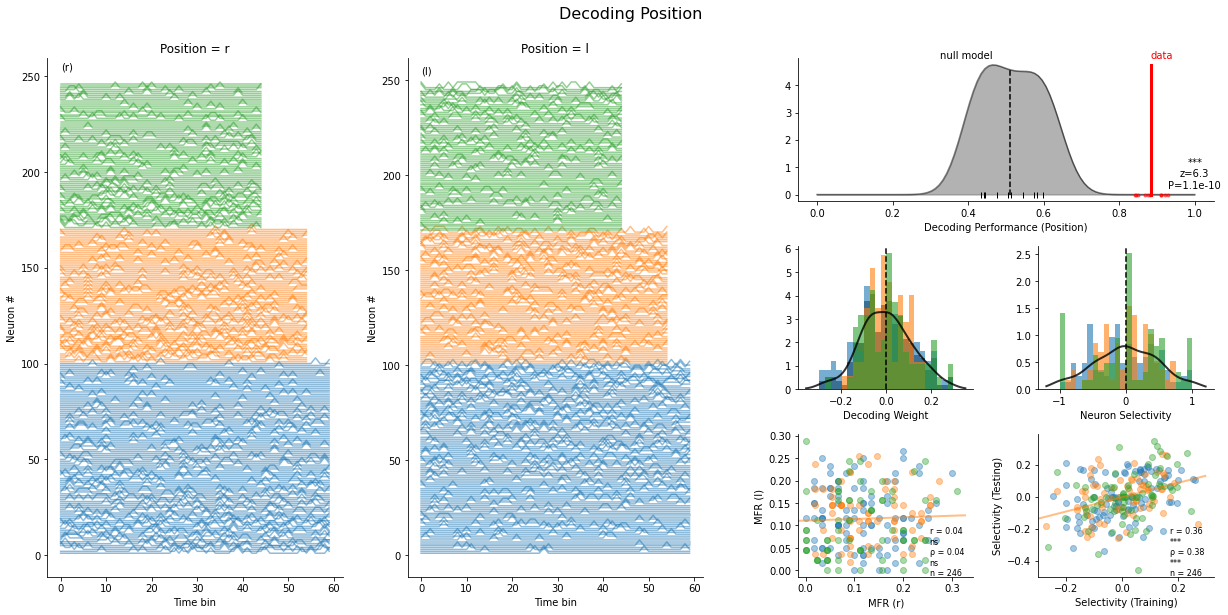

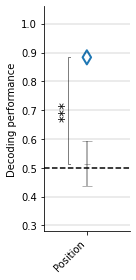

In [11]:
# Pseudo-populations are built by giving a list of sessions instead of just one data set

activity, labels = generate_AB_activity(n_neurons=70, n_trials=110, separation=1.8, labelA='l', labelB='r')

session_1 = {
    'Neural Data': activity,
    'Position': labels,
    'Trial Number': np.arange(len(labels))     # specifying that each vector is an independent trial that we can use for decoding
}

activity, labels = generate_AB_activity(n_neurons=80, n_trials=90, separation=2.5, labelA='l', labelB='r')

session_2 = {
    'Neural Data': activity,
    'Position': labels,
    'Trial Number': np.arange(len(labels))     # specifying that each vector is an independent trial that we can use for decoding
}

mydec = Decodanda(data=[session_0, session_1, session_2],
                  conditions={
                      'Position': ['l', 'r']     # The conditions dictionary takes a simple one-variable list here.
                  },
                  **decodanda_params)

data, null = mydec.decode(**decoding_params)



### Disentangling correlated behavioral variables to avoid confounds
Say we are running an experiment where a subject has to learn a stimulus-action association: when stimulus A pops out on the screen, the subject has to move a lever to the right, when B is presented, the subject needs to move the lever to the left.

In this thought experiment we record from the subject's visual cortex, which we assume only responds to the stimulus, and not to the action.

After training, the subject performs the task with ~ 80% accuracy. Let's create a data set with these three ingredients
- the stimulus label (A, B)
- the action label (left, right)
- the recorded activity, which only responds to stimulus (A, B)

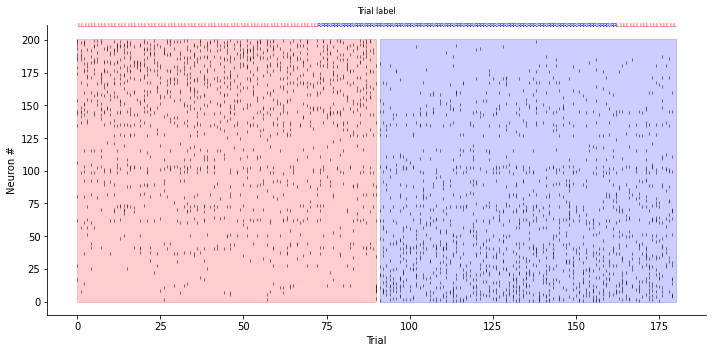

In [12]:
n_neurons = 200 #@param {type:"number"}
n_trials = 180 #@param {type:"number"}

V1_activity, stimulus_labels = generate_AB_activity(n_neurons=n_neurons,
                                                    n_trials=n_trials,
                                                    separation=3.0)

action_labels = np.copy(stimulus_labels)
action_labels[:int(2*n_trials/5)] = 'L'
action_labels[int(2*n_trials/5) : int(9*n_trials/10)] = 'R'
action_labels[int(9*n_trials/10):] = 'L'

f, ax = visualize_AB_activity(action_labels, V1_activity)

ax.fill_between([0, n_trials/2], n_neurons+1, color='r', alpha=0.1)
ax.fill_between([n_trials/2+1, n_trials], n_neurons+1, color='b', alpha=0.1)

ax.fill_between([0, n_trials/2], n_neurons+1, color='r', alpha=0.1)
ax.fill_between([n_trials/2+1, n_trials], n_neurons+1, color='b', alpha=0.1)


If we decode the Stimulus variable from neural activity, we find a very good performance, as we expect.

However we also find a significant performance when we decode Action, even if the activity does not respond to action at all!

This is caused by the Action and Stimulus variable to be correlated, acting as a confound for each other.

({'Action': 0.653888888888889},
 {'Action': array([0.52833333, 0.48055556, 0.46666667, 0.48888889, 0.50444444,
         0.45333333, 0.55722222, 0.52222222, 0.55611111, 0.53111111])})

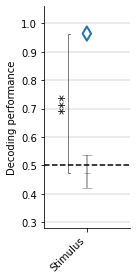

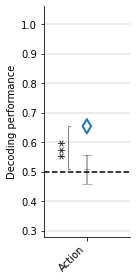

In [13]:
# Creating the data structure

data = {
    'Neural Data': V1_activity,
    'Stimulus': stimulus_labels,
    'Action': action_labels,
    'Trial': np.arange(len(stimulus_labels))
}

# Creating the decodanda object for the Stimulus variable

stimulus_dec = Decodanda(
    data=data,
    conditions={
        'Stimulus': ['A', 'B']
    },
    neural_attr='Neural Data',
    trial_attr='Trial'
)

# Creating the decodanda object for the Action variable

action_dec = Decodanda(
    data=data,
    conditions={
        'Action': ['L', 'R']
    },
    neural_attr='Neural Data',
    trial_attr='Trial'
)

# Decoding the two variables

decoding_params = {
    'training_fraction': 0.8,       # fraction of trials used for training during cross validation
    'cross_validations': 10,        # number of different training-testing separations
    'nshuffles': 10,                 # number of null model repetitions to compute significance
    'plot': True,                   # this generates a recap plot with performance, null model bars, and significance
}

stimulus_dec.decode(**decoding_params)
action_dec.decode(**decoding_params)

This problem can be solved by specifying two conditions in a single ```Decodanda``` object. This ensures that  all variables are properly balanced during decoding of each single variable, effectively breaking the confounding correlation between the two variables.

When calling the ```decode()``` function, ```Decodanda``` will decode both variables in this balanced way. As a result, Stimulus will be decodable, while Action will not, as it should be per construction of the data set.

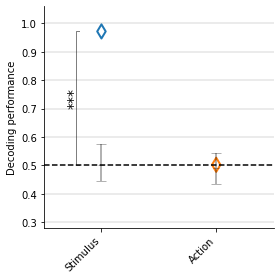

In [14]:
# Creating the decodanda object for the Action variable

my_dec = Decodanda(
    data=data,
    conditions={
        'Stimulus': ['A', 'B'],
        'Action': ['L', 'R']
    },
    neural_attr='Neural Data',
    trial_attr='Trial'
)

res, null = my_dec.decode(**decoding_params)